# Starting

In [2]:
import numpy as np
import torch
import random
import pandas as pd
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [3]:
path = '/root/.cache/kagglehub/datasets/ohagwucollinspatrick/amini-cocoa-contamination-dataset/versions/1'

In [4]:
train_df = pd.read_csv(f'{path}/Train.csv').dropna()
test_df = pd.read_csv(f'{path}/Test.csv')
sample_submission = pd.read_csv(f'{path}/SampleSubmission.csv')

In [5]:
train_df.shape, test_df.shape

((9792, 9), (1626, 9))

In [6]:
display(train_df.head()), train_df[[ 'class_id']].value_counts()

,Image_ID,class,confidence,ymin,xmin,ymax,xmax,class_id,ImagePath
0,ID_nBgcAR.jpg,healthy,1.0,75.0,15.0,162.0,195.0,2,dataset/images/train/ID_nBgcAR.jpg
1,ID_nBgcAR.jpg,healthy,1.0,58.0,1.0,133.0,171.0,2,dataset/images/train/ID_nBgcAR.jpg
2,ID_nBgcAR.jpg,healthy,1.0,42.0,29.0,377.0,349.0,2,dataset/images/train/ID_nBgcAR.jpg
3,ID_Kw2v8A.jpg,healthy,1.0,112.0,124.0,404.0,341.0,2,dataset/images/train/ID_Kw2v8A.jpg
4,ID_Kw2v8A.jpg,healthy,1.0,148.0,259.0,413.0,412.0,2,dataset/images/train/ID_Kw2v8A.jpg


(None,
 class_id
 2           4279
 1           3224
 0           2289
 Name: count, dtype: int64)

In [7]:
train_df[[ 'class']].value_counts()

class      
healthy        4280
cssvd          3241
anthracnose    2271
Name: count, dtype: int64

In [8]:
train_df.loc[train_df['class'] == 'healthy', 'class_id'] = 2
train_df.loc[train_df['class'] == 'cssvd', 'class_id'] = 1
train_df.loc[train_df['class'] == 'anthracnose', 'class_id'] = 0


In [9]:
train_df[[ 'class_id']].value_counts()

class_id
2           4280
1           3241
0           2271
Name: count, dtype: int64

In [10]:
class_mapper = {
    2 : 'healthy',
    1 : 'cssvd',
    0 : 'anthracnose'
}

## Image Format analysis

In [11]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def load_image_dimensions(image_path):
    """Load image and return its width and height."""
    img = Image.open(image_path)
    return img.size

def process_bounding_boxes(label_path, img_width, img_height, class_id):
    """Process bounding boxes from the label file for a specific class."""
    widths, heights, aspect_ratios, areas = [], [], [], []
    with open(label_path, 'r') as f:
        lines = [line.strip().split() for line in f if int(line.strip().split()[0]) == class_id]

    # Convert normalized YOLO coordinates to pixel values and calculate box properties
    for line in lines:
        _, x_center, y_center, width, height = map(float, line)
        x_center, y_center = x_center * img_width, y_center * img_height
        width, height = width * img_width, height * img_height
        aspect_ratio = width / height
        area = width * height
        
        widths.append(width)
        heights.append(height)
        aspect_ratios.append(aspect_ratio)
        areas.append(area)

    return widths, heights, aspect_ratios, areas

def plot_histogram(data, ax, title, xlabel, ylabel):
    """Plot histogram of data."""
    ax.hist(data, bins=50, color='skyblue', edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

def plot_class_distribution(class_mapper, images_per_class):
    """Plot class distribution."""
    class_counts = list(images_per_class.values())
    plt.figure(figsize=(8, 6))
    plt.bar(class_mapper.values(), class_counts, color='skyblue', edgecolor='black')
    plt.title('Number of Images per Class')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.show()

def perform_eda(path, class_mapper):
    # Variables to store data for analysis
    image_widths, image_heights, aspect_ratios = [], [], []
    bounding_box_widths, bounding_box_heights = [], []
    bounding_box_aspect_ratios, bounding_box_areas = [], []
    images_per_class = {CLASS: 0 for CLASS in class_mapper}  # Initialize class counters

    # Iterate through each class and process images
    for CLASS, cname in class_mapper.items():
        for image_file in os.listdir(os.path.join(path, "images", 'train')):
            label_file = os.path.splitext(image_file)[0] + '.txt'
            label_path = os.path.join(path, "labels", 'train', label_file)
            image_path = os.path.join(path, "images", 'train', image_file)

            # Skip if label file does not exist
            if not os.path.exists(label_path):
                continue

            # Read image dimensions
            img_width, img_height = load_image_dimensions(image_path)
            image_widths.append(img_width)
            image_heights.append(img_height)
            aspect_ratios.append(img_width / img_height)

            # Process bounding boxes
            widths, heights, aspect_ratios_box, areas = process_bounding_boxes(
                label_path, img_width, img_height, CLASS
            )
            bounding_box_widths.extend(widths)
            bounding_box_heights.extend(heights)
            bounding_box_aspect_ratios.extend(aspect_ratios_box)
            bounding_box_areas.extend(areas)

            # Track image count per class
            images_per_class[CLASS] += 1

    # Plot image dimensions distributions
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))
    plot_histogram(image_widths, axes[0, 0], 'Distribution of Image Widths', 'Width', 'Frequency')
    plot_histogram(image_heights, axes[0, 1], 'Distribution of Image Heights', 'Height', 'Frequency')
    plot_histogram(aspect_ratios, axes[1, 0], 'Distribution of Aspect Ratios', 'Aspect Ratio (Width / Height)', 'Frequency')
    plot_histogram(bounding_box_widths, axes[1, 1], 'Bounding Box Width Distribution', 'Bounding Box Width', 'Frequency')
    plot_histogram(bounding_box_heights, axes[2, 0], 'Bounding Box Height Distribution', 'Bounding Box Height', 'Frequency')
    plot_histogram(bounding_box_areas, axes[2, 1], 'Bounding Box Area Distribution', 'Bounding Box Area', 'Frequency')

    plt.tight_layout()
    plt.show()

    # Plot class distribution
    plot_class_distribution(class_mapper, images_per_class)


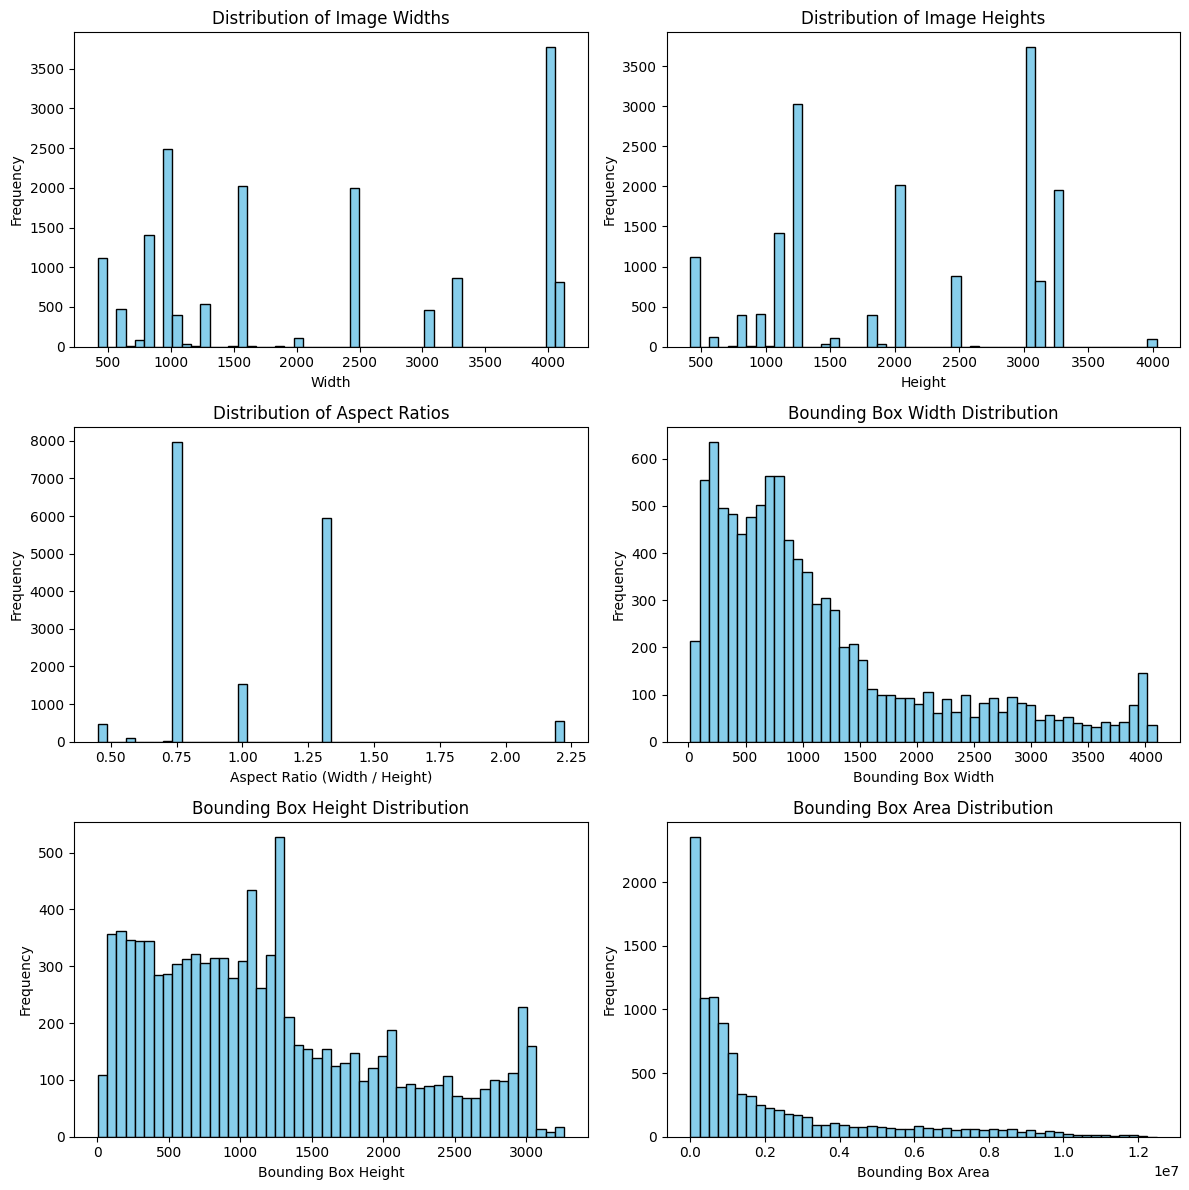

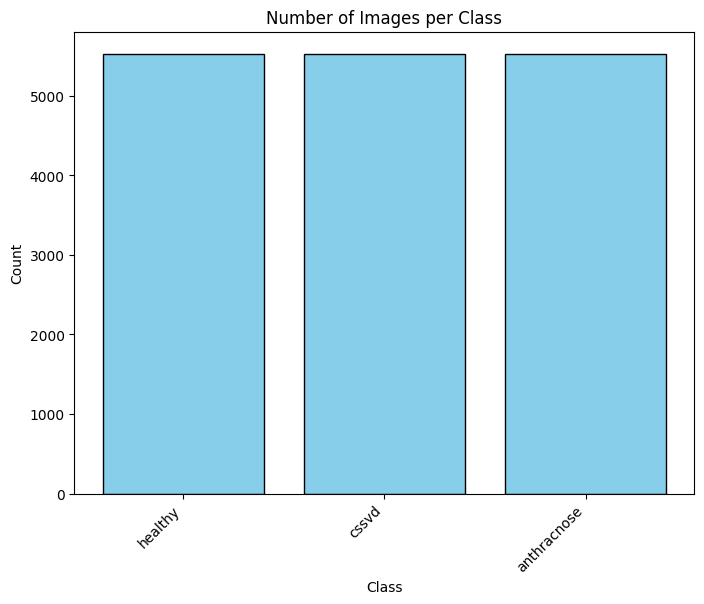

In [12]:
perform_eda(path+'/dataset', class_mapper)


## Color analysis

In [27]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import colorsys

def rgb_to_hsv(image):
    """Convert an image from RGB to HSV and return the Hue, Saturation, Value channels."""
    return image.convert('HSV')

def get_rgb_and_hue(image_path):
    """Extract RGB values and Hue from an image."""
    img = Image.open(image_path)
    hsv_image = rgb_to_hsv(img)
    hsv_pixels = np.array(hsv_image)
    
    # Extract RGB channels
    rgb_pixels = np.array(img)
    red_channel = rgb_pixels[:, :, 0].flatten()
    green_channel = rgb_pixels[:, :, 1].flatten()
    blue_channel = rgb_pixels[:, :, 2].flatten()

    # Extract Hue channel
    hue_channel = hsv_pixels[:, :, 0].flatten()

    return red_channel, green_channel, blue_channel, hue_channel

def plot_rgb_distribution_by_hue(path, hue_thresholds):
    """Plot RGB distribution by hue classes."""
    red_values, green_values, blue_values = [], [], []
    hue_values = []

    # Iterate through all images in the training set
    for image_file in os.listdir(path):
        image_path = os.path.join(path, image_file)

        # Get RGB and Hue values for the image
        red_channel, green_channel, blue_channel, hue_channel = get_rgb_and_hue(image_path)

        red_values.extend(red_channel)
        green_values.extend(green_channel)
        blue_values.extend(blue_channel)
        hue_values.extend(hue_channel)

    # Convert hue values to numpy array for processing
    hue_values = np.array(hue_values)

    # Plot histograms for each hue range
    fig, axes = plt.subplots(len(hue_thresholds), 3, figsize=(12, 12))
    axes = axes.ravel()

    for i, (lower, upper) in enumerate(hue_thresholds):
        # Filter images by hue range
        hue_mask = (hue_values >= lower) & (hue_values < upper)
        filtered_red = np.array(red_values)[hue_mask]
        filtered_green = np.array(green_values)[hue_mask]
        filtered_blue = np.array(blue_values)[hue_mask]

        # Plot RGB distributions for the current hue range
        axes[i * 3].hist(filtered_red, bins=50, color='red', alpha=0.7)
        axes[i * 3].set_title(f'Red Distribution (Hue: {lower} - {upper})')
        axes[i * 3].set_xlabel('Red Value')
        axes[i * 3].set_ylabel('Frequency')

        axes[i * 3 + 1].hist(filtered_green, bins=50, color='green', alpha=0.7)
        axes[i * 3 + 1].set_title(f'Green Distribution (Hue: {lower} - {upper})')
        axes[i * 3 + 1].set_xlabel('Green Value')
        axes[i * 3 + 1].set_ylabel('Frequency')

        axes[i * 3 + 2].hist(filtered_blue, bins=50, color='blue', alpha=0.7)
        axes[i * 3 + 2].set_title(f'Blue Distribution (Hue: {lower} - {upper})')
        axes[i * 3 + 2].set_xlabel('Blue Value')
        axes[i * 3 + 2].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Define hue ranges (this can be adjusted depending on your color classification)
hue_thresholds = [(0, 30), (30, 90), (90, 150), (150, 210), (210, 270), (270, 330), (330, 360)]

In [ ]:
# plot_rgb_distribution_by_hue(path+'/dataset/images/train', hue_thresholds)

: 

: 

: 

### Band Matrix analysis

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

band_colors = ['Red', 'Green', 'Blue']
    
def extract_channel(image, box, band=0):
    """Extract the band channel within a bounding box."""
    x_min, y_min, x_max, y_max = box
    band_channel = image[y_min:y_max, x_min:x_max, band]  # Red channel is the first channel (0)
    return band_channel

def process_image(image_path, label_path, class_mapper, band=0):
    """Process an image and extract Red channel values for the bounding boxes."""
    img = Image.open(image_path)
    img = img.resize((640, 640))  # Resize image to 1024x1024
    img = np.array(img)  # Convert image to numpy array (RGB)

    # Read label file and extract bounding boxes
    with open(label_path, 'r') as f:
        lines = f.readlines()

    band_channel_matrices = {class_id: [] for class_id in class_mapper.keys()}  # Dictionary to store red channel values per class

    # Process each bounding box in the label file
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())

        if class_id not in band_channel_matrices:
            continue  # Skip bounding boxes of classes that are not in the class_mapper

        # Convert YOLO format (normalized) to pixel coordinates
        img_height, img_width = img.shape[:2]
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height

        # Calculate the bounding box corners (x_min, y_min, x_max, y_max)
        x_min = int(x_center - width / 2)
        y_min = int(y_center - height / 2)
        x_max = int(x_center + width / 2)
        y_max = int(y_center + height / 2)

        # Extract the Red channel values for this bounding box
        band_values = extract_channel(img, (x_min, y_min, x_max, y_max), band=band)
        band_channel_matrices[int(class_id)].append(band_values)

    return band_channel_matrices

def plot_band_values_per_class(band_channel_matrices, class_mapper, band=0):
    """Plot the distribution of band channel values for each class in a single figure with reduced opacity and KDE."""
    plt.figure(figsize=(12, 8))

    # Loop through each class to plot the red channel values and the density plot
    for class_id, band_values_list in band_channel_matrices.items():
        # Flatten all red channel matrices for the current class
        flattened_band_values = np.concatenate([band_matrix.flatten() for band_matrix in band_values_list])
        COLOR = np.random.rand(3,)
        
        # Plot the Kernel Density Estimate (KDE) plot for smooth visualization of the distribution
        sns.kdeplot(flattened_band_values, color=COLOR, linestyle='-', linewidth=2, label=f'{class_mapper[class_id]} KDE', fill=True, alpha=0.2)

    # Set plot title and labels
    plt.title(f'{band_colors[band]} Channel Distribution and Density Plot for All Classes')
    plt.xlabel(f'{band_colors[band]} Channel Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

def process_and_plot(path, class_mapper, num_images=10, band=0):
    print(f"Processing {band_colors[band]} channel values...")
    
    """Process images and plot the Red channel distribution for each class."""
    band_channel_matrices = {class_id: [] for class_id in class_mapper.keys()}  # Store all red channel values across all images

    # Process images
    processed_images = 0
    for image_file in os.listdir(os.path.join(path, "images", 'train')):
        if processed_images >= num_images:
            break

        image_path = os.path.join(path, "images", 'train', image_file)
        label_file = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(path, "labels", 'train', label_file)

        if not os.path.exists(label_path):
            continue

        # Process the image and extract Red channel values
        band_channel_matrices_image = process_image(image_path, label_path, class_mapper, band=band)

        # Collect the Red channel values for each class (Accumulate over all images)
        for class_id, band_values_list in band_channel_matrices_image.items():
            band_channel_matrices[class_id].extend(band_values_list)

        processed_images += 1
    
    print(f"Processed {processed_images} images.")
    
    # Plot the results
    plot_band_values_per_class(band_channel_matrices, class_mapper, band=band)


Processing Red channel values...
Processed 100 images.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


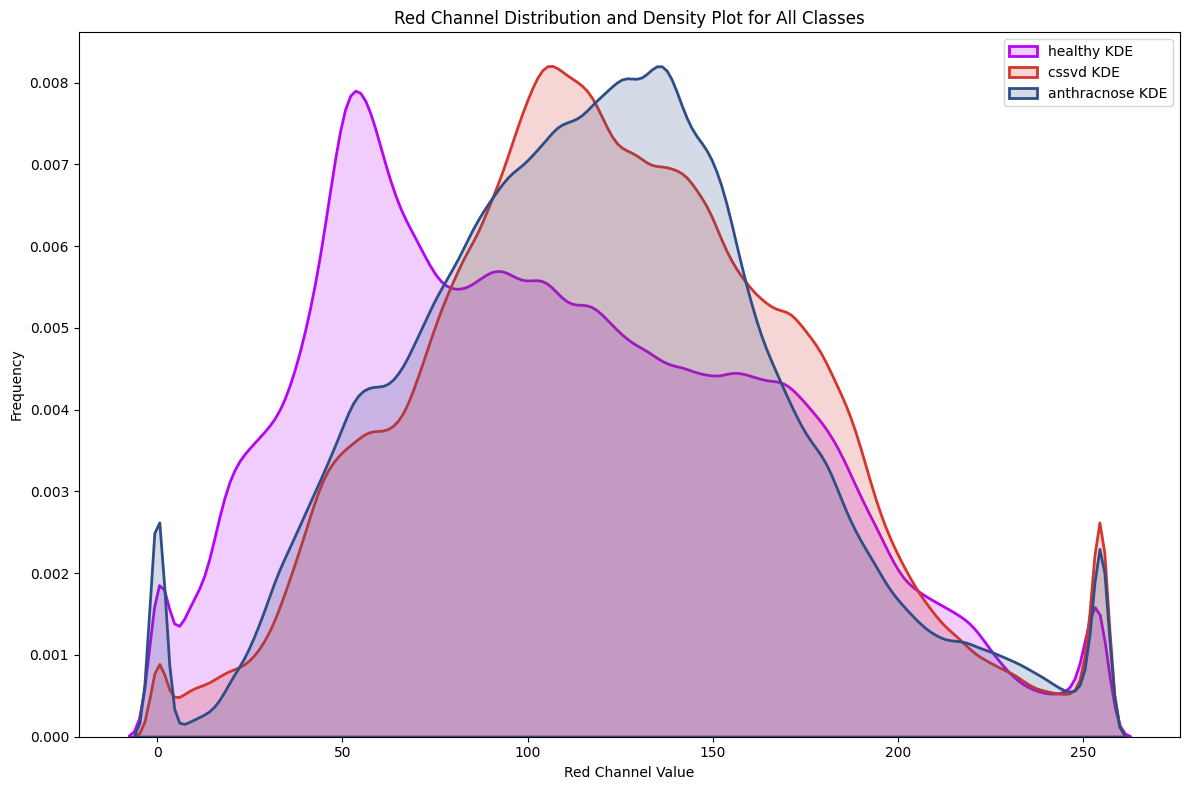

In [18]:
process_and_plot(path+'/dataset', class_mapper, num_images=100)

Processing Green channel values...
Processed 1000 images.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


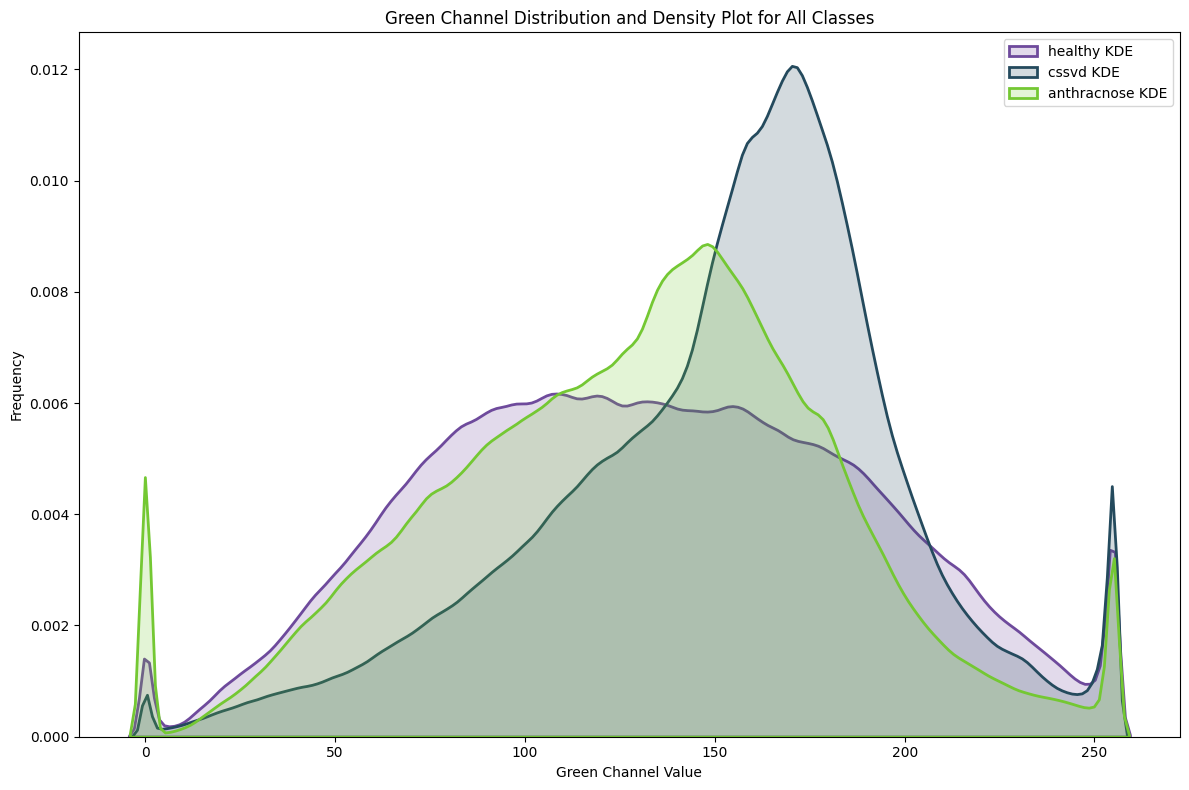

In [19]:
process_and_plot(path+'/dataset', class_mapper, num_images=1000, band=1)  # Green channel


In [26]:
os.path.join(path, "images", 'train', train_df.iloc[0]['Image_ID'])

'/root/.cache/kagglehub/datasets/ohagwucollinspatrick/amini-cocoa-contamination-dataset/versions/1/images/train/ID_nBgcAR.jpg'

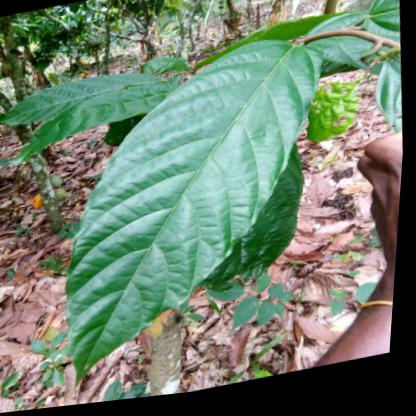

In [28]:
Image.open(os.path.join(path, "dataset/images", 'train', train_df.iloc[0]['Image_ID'])).show()

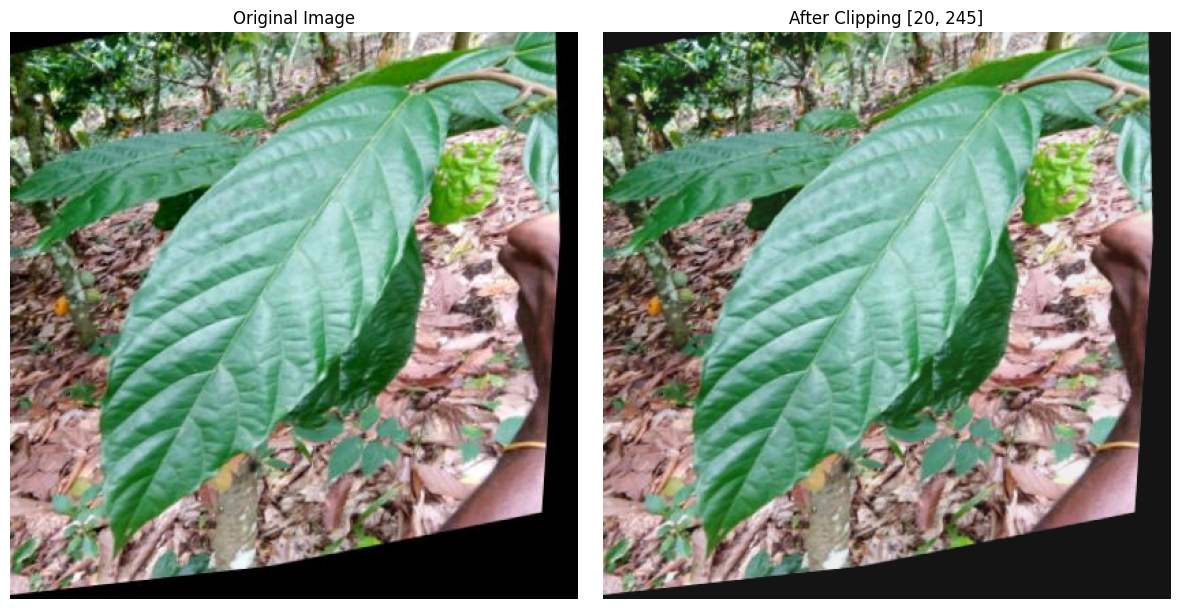

In [33]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have access to 'path' and 'train_df'
image_path = os.path.join(path, "dataset/images", 'train', train_df.iloc[0]['Image_ID'])
image = Image.open(image_path)

# Convert image to numpy array for processing
image_np = np.array(image)

# Show the original image
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis('off')

# Apply the rescaling or clipping transformation
# Clipping pixel values to the range [20, 245]
image_clipped = np.clip(image_np, 20, 240)

# Convert back to an image for displaying
image_clipped_pil = Image.fromarray(image_clipped.astype(np.uint8))

# Display the modified image
plt.subplot(1, 2, 2)
plt.imshow(image_clipped_pil)
plt.title("After Clipping [20, 245]")
plt.axis('off')

plt.tight_layout()
plt.show()


Original Image Pixel Value Range: min = 0, max = 255
Clipped Image Pixel Value Range: min = 20, max = 240


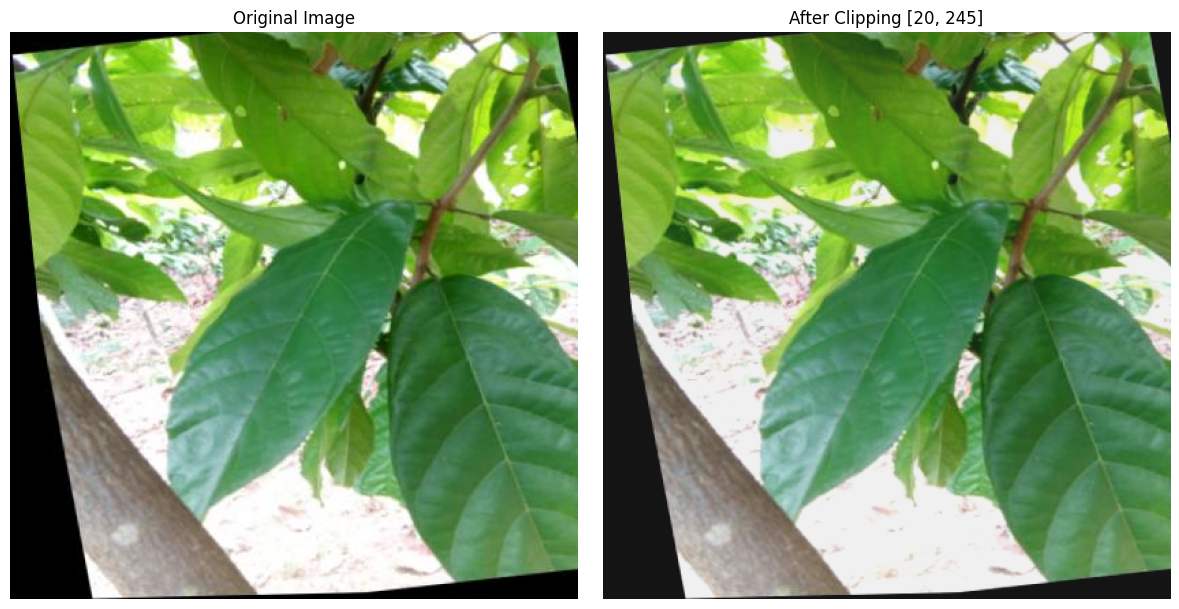

In [36]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have access to 'path' and 'train_df'
image_path = os.path.join(path, "dataset/images", 'train', train_df.iloc[100]['Image_ID'])
image = Image.open(image_path)

# Convert image to numpy array for processing
image_np = np.array(image)

# Show the original image
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Original Image")
plt.axis('off')

# Print statistics of original image
print(f"Original Image Pixel Value Range: min = {image_np.min()}, max = {image_np.max()}")

# Apply the rescaling or clipping transformation
# Clipping pixel values to the range [20, 245]
image_clipped = np.clip(image_np, 20, 240)

# Print statistics of clipped image
print(f"Clipped Image Pixel Value Range: min = {image_clipped.min()}, max = {image_clipped.max()}")

# Convert back to an image for displaying
image_clipped_pil = Image.fromarray(image_clipped.astype(np.uint8))

# Display the modified image
plt.subplot(1, 2, 2)
plt.imshow(image_clipped_pil)
plt.title("After Clipping [20, 245]")
plt.axis('off')

plt.tight_layout()
plt.show()
